In [1]:
import pandas as pd

In [49]:
cols = [
    "STCNTY",
    "FIPS",
    "E_TOTPOP",
    "E_AFAM",
    "E_HISP",
    "E_ASIAN",
    "E_AIAN",
    "E_NHPI",
    "E_TWOMORE",
    "E_OTHERRACE"]

In [50]:
df = pd.read_csv("data/California.csv", usecols=cols, dtype={"FIPS":str})

In [51]:
df.head()

,STCNTY,FIPS,E_TOTPOP,E_AFAM,E_HISP,E_ASIAN,E_AIAN,E_NHPI,E_TWOMORE,E_OTHERRACE
0,6001,06001400100,3035,94,125,424,0,0,170,17
1,6001,06001400200,1983,44,163,219,6,0,211,7
2,6001,06001400300,5058,433,463,773,6,34,209,55
3,6001,06001400400,4179,278,473,418,27,0,282,6
4,6001,06001400500,4021,1101,359,387,0,0,377,0


In [52]:
df['E_WHITE'] = df['E_TOTPOP'] - df[['E_AFAM', 'E_HISP', 'E_ASIAN', 'E_AIAN', 'E_NHPI', 'E_TWOMORE', 'E_OTHERRACE']].sum(axis=1)

# Exposure per FIPS over time

In [103]:
exposure = pd.read_parquet("outputs/hotspots_per_fips_rolling.parquet")

In [104]:
exposure = exposure.groupby("FIPS").sum()

/var/folders/b_/vlxgm9n10bz569rffzmcc5dc0000gn/T/ipykernel_29369/723284542.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  exposure = exposure.groupby("FIPS").sum()


In [105]:
exposure.head()

,wfday,heatday,coldday,polluted,smoke_polluted,ws,hw,hp,hs,hwp,hws,hwps
FIPS,,,,,,,,,,,,
1765.0,0,311,255,34,433,0,0,7,61,0,0,778
1766.0,0,319,265,55,410,0,0,8,51,0,0,784
1767.0,0,319,265,55,410,0,0,8,51,0,0,784
1768.0,1,319,265,49,410,0,1,8,51,0,0,779
1769.0,1,319,265,56,410,0,0,8,51,0,0,786


In [48]:
crosswalk = pd.read_csv(
    "data/fips_crosswalk_merged_county.csv", 
    usecols=["FIPS", "long_FIPS"],
    dtype={"long_FIPS":int})

In [53]:
df.FIPS = df.FIPS.astype(int)

In [54]:
crosswalk = df.merge(
    crosswalk,
    left_on="FIPS",
    right_on="long_FIPS")

In [55]:
crosswalk = crosswalk.merge(
    exposure,
    left_on="FIPS_y",
    right_on="FIPS")

In [180]:
df = crosswalk

In [181]:
df.columns

Index(['STCNTY', 'FIPS_x', 'E_TOTPOP', 'E_AFAM', 'E_HISP', 'E_ASIAN', 'E_AIAN',
       'E_NHPI', 'E_TWOMORE', 'E_OTHERRACE', 'E_WHITE', 'long_FIPS', 'FIPS_y',
       'wfday', 'heatday', 'coldday', 'polluted', 'smoke_polluted', 'ws', 'hw',
       'hp', 'hs', 'hwp', 'hws', 'hwps', 'exposure_category',
       'E_AFAM_normalized', 'E_HISP_normalized', 'E_ASIAN_normalized',
       'E_AIAN_normalized', 'E_NHPI_normalized', 'E_TWOMORE_normalized',
       'E_OTHERRACE_normalized', 'E_WHITE_normalized', 'E_TOTPOP_normalized'],
      dtype='object')

In [182]:
demographic_cols = [
    "E_AFAM",
    "E_HISP",
    "E_ASIAN",
    "E_AIAN",
    "E_NHPI",
    "E_TWOMORE",
    "E_OTHERRACE",
    "E_WHITE",
    "E_TOTPOP"
]

In [185]:
import seaborn as sns

In [220]:
def plot_qbar(exposure_per_category, htsp):
    # Plot the bar chart
    # ax = exposure_per_category.plot(kind='bar', figsize=(8, 5))

    # Melt the DataFrame to long format
    epc = exposure_per_category.reset_index().melt(id_vars='exposure_category',
                                            var_name='Race', value_name='Proportion')


    # Plot the bar chart using Seaborn
    plt.figure(figsize=(8, 5))
    sns.barplot(data=epc, x='exposure_category', y='Proportion', hue='Race')

    plt.title('Quantile-based demographic discretization per ' +htsp+ ' exposure level')
    plt.ylabel('Proportion of the demographic group (%)')
    plt.xlabel('Exposure level (higher is worse)')
    plt.legend(title='Year',  loc='upper left', bbox_to_anchor=(1., 1))
    plt.xticks(rotation=0)
    #ax.set_yscale('log')
    plt.tight_layout()
    plt.show()

In [221]:
hotspots = {
     'ws':{'func':pd.cut}, 
     'hw':{'func':pd.cut}, 
     'hp':{'func':pd.qcut}, 
     'hs':{'func':pd.qcut}, 
     'hwp':{'func':pd.cut}, 
     'hws':{'func':pd.cut}, 
     'hwps':{'func':pd.qcut}
 }

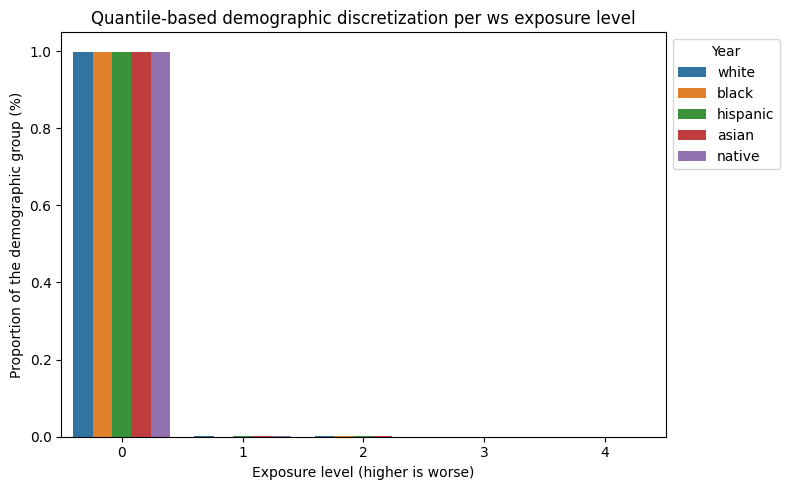

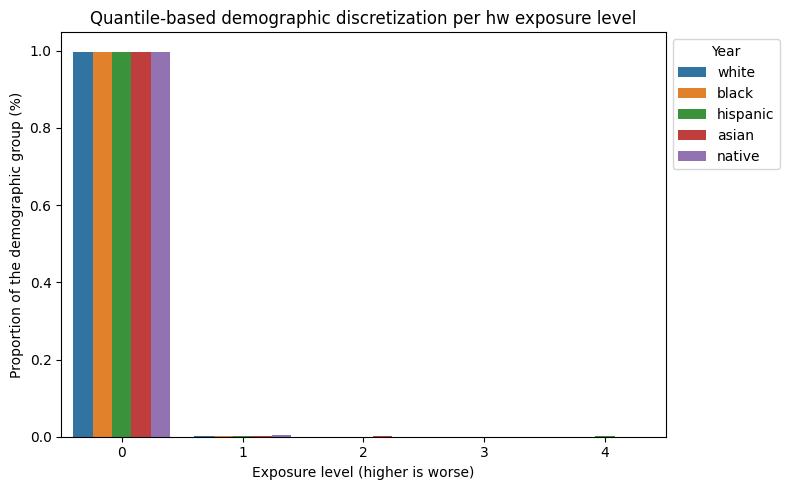

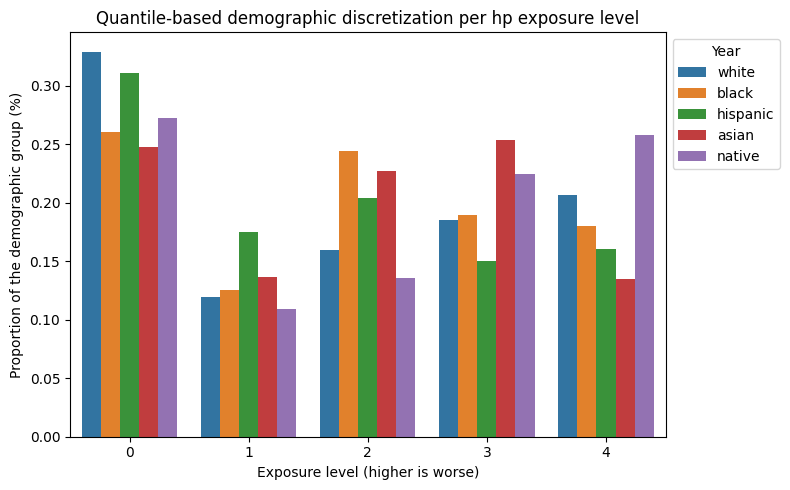

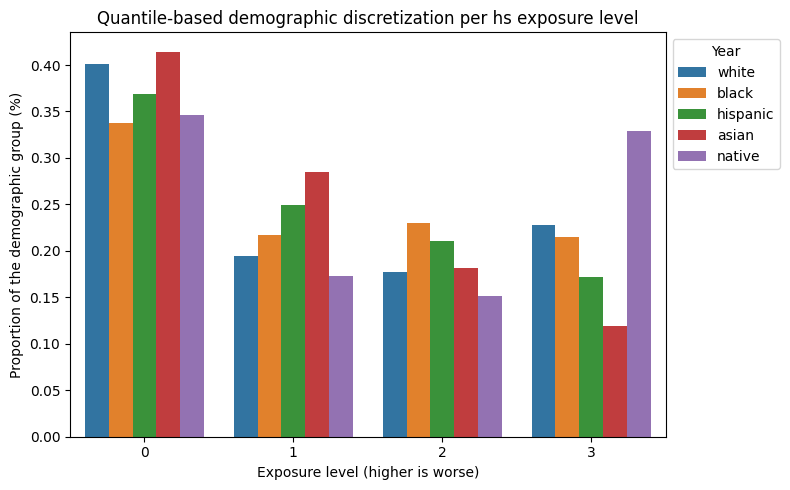

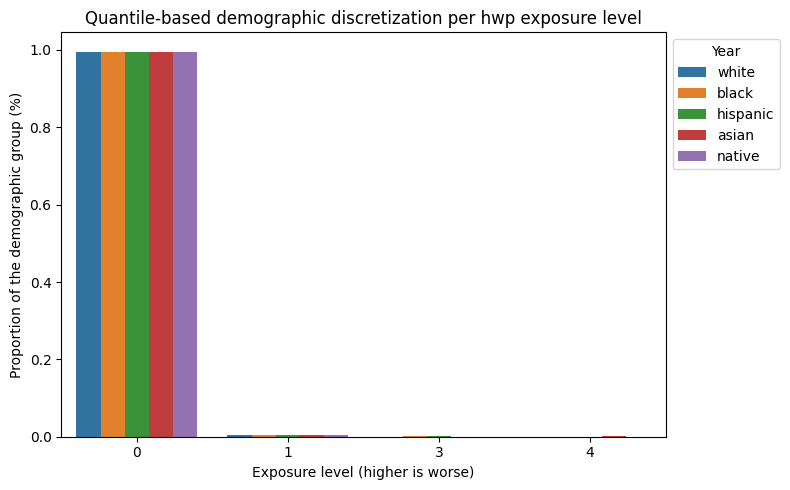

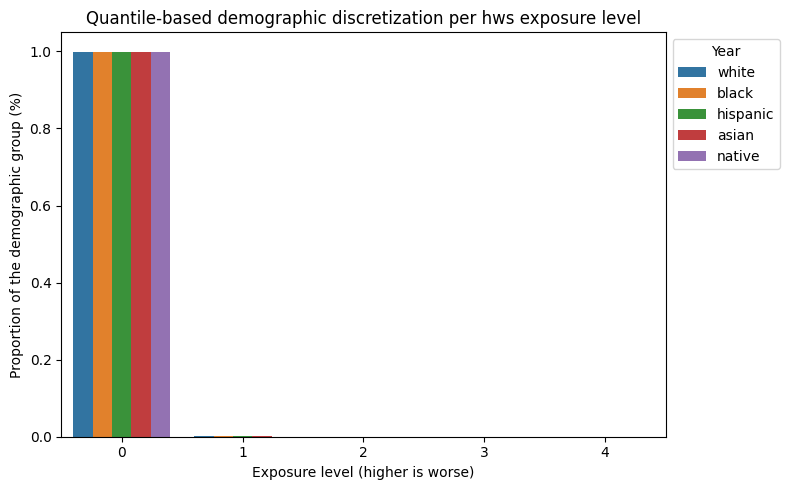

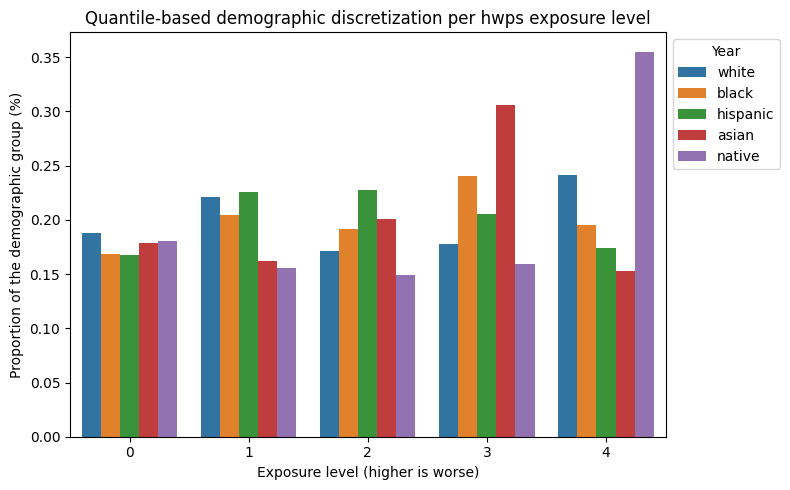

In [222]:
for hspt in hotspots.keys():
    df = crosswalk
    df['exposure_category'] = hotspots[hspt]['func'](df[hspt], 5, labels=False, duplicates='drop')

    exposure_per_category = df.groupby("exposure_category")[demographic_cols].sum()

    for dc in demographic_cols:
        exposure_per_category[dc+'_normalized'] = exposure_per_category[dc] / exposure_per_category[dc].sum()

    exposure_per_category = exposure_per_category.drop(columns=demographic_cols)

    exposure_per_category = exposure_per_category.drop(columns=['E_TOTPOP_normalized', 
           'E_NHPI_normalized', 'E_TWOMORE_normalized',
           'E_OTHERRACE_normalized'])

    exposure_per_category = exposure_per_category[["E_WHITE_normalized","E_AFAM_normalized",
                                                   "E_HISP_normalized",
                                                   "E_ASIAN_normalized",
                                                   "E_AIAN_normalized"]]

    exposure_per_category = exposure_per_category.rename(columns={"E_WHITE_normalized":"white",
                                                         "E_AFAM_normalized":"black",
                                                   "E_HISP_normalized":"hispanic",
                                                   "E_ASIAN_normalized":"asian",
                                                   "E_AIAN_normalized":"native"})
    plot_qbar(exposure_per_category, hspt)